Sheet 5.1: Character-level sequence modeling w/ RNNs
====================================================

**Author:** Michael Franke



The goal of this tutorial is to get familiar with simple language models.
To be able to have a manageable (quick to train, evaluate, inspect) case study, we look at character-level predictions of surnames from different languages.
(The inspiration and source of this notebook is [this tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html) from PyTorch&rsquo;s documentation.)



## Packages & global parameters



In addition to the usual packages for neural network modeling, we will also require packages for I/O and string handling.



In [1]:
##################################################
## import packages
##################################################

from __future__ import unicode_literals, print_function, division
from io import open
import json
import glob
import os
import unicodedata
import pandas
import string
import torch
import numpy as np
import torch.nn as nn
import random
import time
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Loading & inspecting the data



Our training data are lists of surnames from different countries.
We will use this data set to train a model that predicts a name, given the country as a prompt.

The (pre-processed) data is stored in a JSON file.
We load it and define a few useful variables for later use.



In [1]:
##################################################
## read and inspect the data
##################################################

os.chdir("/Users/micha/Library/Mobile Documents/com~apple~CloudDocs/xxx_sync_xxx/Work/Teaching/2022b-npNLG/book-repo/neural_pragmatic_nlg/05-NLMs/")

with open('names-data.json') as dataFile:
    namesData = json.load(dataFile)

categories = list(namesData.keys())
n_categories   = len(categories)

# we use all ASCII letters as the vocabulary (plus tokens [EOS], [SOS])
all_letters = string.ascii_letters + " .,;'-"
n_letters   = len(all_letters) + 2 # all letter plus [EOS] and [SOS] token
SOSIndex    = n_letters - 1
EOSIndex    = n_letters - 2

The data consists of two things:
a list of strings, called &ldquo;categories&rdquo;, contains all the categories (languages) for which we have data;
a dictionary, called &ldquo;namesData&rdquo;, contains a list of names for each category.

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 5.1.1: Inspect the data</span></strong>
>
> 0. [Just for yourself.] Find out what&rsquo;s in the data set. How any different countries do we have? How many names per country? Are all names unique in a given country? Do the names sound typical to your ears for the given countries?



## Train-test split



We will split the data into a training and a test set.
Look at the code and try to answer the exercise question of how this split is realized.



In [1]:
##################################################
## make a train/test split
##################################################

train_data = dict()
test_data  = dict()
split_percentage = 10
for k in list(namesData.keys()):
    total_size    = len(namesData[k])
    test_size     = round(total_size/split_percentage)
    train_size    = total_size - test_size
    print(k, total_size, train_size, test_size)
    indices       = [i for i in range(total_size)]
    random.shuffle(indices)
    train_indices = indices[0:train_size]
    test_indices  = indices[(train_size+1):(-1)]
    train_data[k] = [namesData[k][i] for i in train_indices]
    test_data[k]  = [namesData[k][i] for i in test_indices]

#+begin_example
Czech 519 467 52
German 724 652 72
Arabic 2000 1800 200
Japanese 991 892 99
Chinese 268 241 27
Vietnamese 73 66 7
Russian 9408 8467 941
French 277 249 28
Irish 232 209 23
English 3668 3301 367
Spanish 298 268 30
Greek 203 183 20
Italian 709 638 71
Portuguese 74 67 7
Scottish 100 90 10
Dutch 297 267 30
Korean 94 85 9
Polish 139 125 14
#+end_example

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 5.1.2: Explain the train-test split</span></strong>
>
> 1. How is the original data information split into training and test set? (E.g., what amount of data is allocated to each part?; is the split exclusive and exhaustive?; how is it determined which items goes where?)



## Defining the model



The model we use is a (hand-crafted) recurrent neural network.
The architecture follows [this tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html), from where we also borrow the following picture:

![img](./../pics/05-RNN-diagram.png)

The model makes consecutive predictions about the next character.
It is conditioned on three vectors:

1.  &rsquo;category&rsquo; is a one-hot vector encoding the country
2.  &rsquo;input&rsquo; is a one-hot vector encoding the character
3.  &rsquo;hidden&rsquo; is the RNN&rsquo;s hidden state (remembering what happened before)

These vectors are first combined and then used to produce a next-character probability distribution *and* the hidden state to be fed into the next round of predictions.

Next to the usual functions (initialization and forward pass), there is also a function that returns a blank &rsquo;hidden state&rsquo;.
This will be used later during training and inference, because at the start of each application (training or inference) the RNN should have a blank memory.
(It makes sense to include this function in the definition of the module because it depends on the module&rsquo;s parameters (size of the hidden layer).)

Notice that the architecture features a dropout layer, which randomly sets a fixed proportion of units to 0.
The inclusion of dropout introduces a random element in the model during training and inference.



In [1]:
##################################################
## define RNN
##################################################

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout = 0.1):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(n_categories + input_size + hidden_size,
                             hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size,
                             output_size)
        self.o2o = nn.Linear(hidden_size + output_size,
                             output_size)
        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 5.1.3: Inspect the model</span></strong>
>
> 0. [Just for yourself.] Make sure that you understand the model architecture and its implementation. E.g., do you agree that this code implements the model graph shown above? Can you think of slight alterations to the model which might also work?



## Helper functions for training



For training, we will present the model with randomly sampled single items.
This is why we define a &rsquo;randomTrainingPair&rsquo; function which returns, well, a random training pair (category and name).



In [1]:
##################################################
## helper functions for training
##################################################

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(categories)
    line = randomChoice(train_data[category])
    return category, line

We also need to make sure that the training and test data are in a format that the model understands.
So, this is where we use vector representations for the categories and sequences of characters.
For sequences of characters we distinguish those used as input to the model (&rsquo;inputTensor&rsquo;) and those used in training as what needs to be predicted (&rsquo;targetTensor&rsquo;).



In [1]:
# One-hot vector for category
def categoryTensor(category):
    li = categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including [EOS]) for input
# The first input is always [SOS]
def inputTensor(line):
    tensor = torch.zeros(len(line)+1, 1, n_letters)
    tensor[0][0][SOSIndex] = 1
    for li in range(len(line)):
        letter = line[li]
        tensor[li+1][0][all_letters.find(letter)] = 1
    return tensor

def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(len(line))]
    letter_indexes.append(EOSIndex)
    return torch.LongTensor(letter_indexes)

Finally, we construct a function that returns a random training pair in the proper vectorized format.



In [1]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 5.1.4: Understand the representational format </span></strong>
>
> 1. Write a doc-string for the function &rsquo;randomTrainingExample&rsquo; that is short but completely explanatory regarding the format and meaning of its output.

We use this timing function to keep track of training time:



In [1]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

## Training the network



This function captures a single training step for one training triplet (category, input representation of the name, output representation of the string).

What is important to note here is that at the start of each &ldquo;name&rdquo;, so to speak, we need to supply a fresh &rsquo;hidden layer&rsquo;, but that subsequent calls to the RNN&rsquo;s forward pass function will use the hidden layer that is returned from the previous forward pass.



In [1]:
##################################################
## single training pass
##################################################

def train(category_tensor, input_line_tensor, target_line_tensor):
    # reshape target tensor
    target_line_tensor.unsqueeze_(-1)
    # get a fresh hidden layer
    hidden = rnn.initHidden()
    # reset cumulative loss
    optimizer.zero_grad()
    loss = 0
    # zero the gradients
    # sequentially probe predictions and collect loss
    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l
    # perform backward pass
    loss.backward()
    # perform optimization
    optimizer.step()
    # return prediction and loss
    return loss.item() # / input_line_tensor.size(0)

The actual training process is furthermore not very special.



In [1]:
##################################################
## actual training loop
## (should take about 2-4 minutes)
##################################################

# instantiate the model
rnn = RNN(n_letters, 128, n_letters)
# training objective
criterion = nn.NLLLoss()
# learning rate
learning_rate = 0.0005
# optimizer
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
# training parameters
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # will be reset every 'plot_every' iterations

start = time.time()

for iter in range(1, n_iters + 1):
    loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

    if iter % print_every == 0:
        rolling_mean = np.mean(all_losses[iter - print_every*(iter//print_every):])
        print('%s (%d %d%%) %.4f' % (timeSince(start),
                                     iter,
                                     iter / n_iters * 100,
                                     rolling_mean))

#+begin_example
80m 5s (5000 5%) 19.6363
80m 11s (10000 10%) 18.7941
80m 17s (15000 15%) 18.4141
80m 22s (20000 20%) 18.1456
80m 28s (25000 25%) 17.9378
80m 34s (30000 30%) 17.7983
80m 40s (35000 35%) 17.6838
80m 45s (40000 40%) 17.5830
80m 51s (45000 45%) 17.5028
80m 57s (50000 50%) 17.4271
81m 2s (55000 55%) 17.3638
81m 8s (60000 60%) 17.3185
81m 14s (65000 65%) 17.2827
81m 19s (70000 70%) 17.2372
81m 25s (75000 75%) 17.2034
81m 31s (80000 80%) 17.1626
81m 36s (85000 85%) 17.1384
81m 42s (90000 90%) 17.1076
81m 48s (95000 95%) 17.0833
81m 54s (100000 100%) 17.0642
#+end_example

Here is a plot of the temporal development of the model&rsquo;s performance during training:



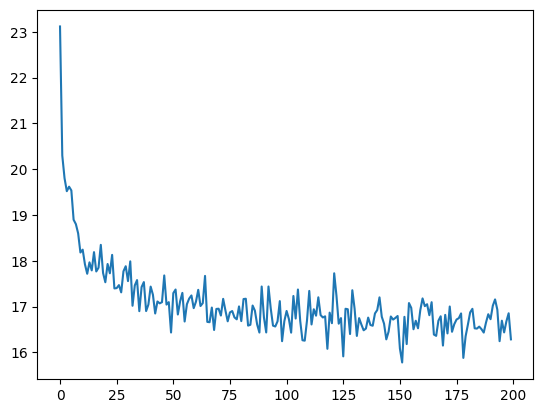

In [1]:
##################################################
## monitoring loss function during training
##################################################

plt.figure()
plt.plot(all_losses)
plt.show()

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 5.1.5: Investigate the training regime </span></strong>
>
> 1. What exactly is the loss function here? What are we training the model on: perplexity, average surprisal, or yet something else?



## Evaluation & inference



Let&rsquo;s see what the model has learned and how well it does in producing new names.

Here are some auxiliary functions to obtain surprisal values and related notions for sequences of characters.
We can use them to compare the model&rsquo;s performance on the training and test data set.



In [1]:
##################################################
## evaluation
##################################################

def get_surprisal_item(category, name):
    category_tensor    = categoryTensor(category)
    input_line_tensor  = inputTensor(name)
    target_line_tensor = targetTensor(name)
    hidden             = rnn.initHidden()
    surprisal          = 0
    target_line_tensor.unsqueeze_(-1)

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        surprisal += criterion(output, target_line_tensor[i])
    return(surprisal.item())

def get_surprisal_dataset(data):
    surprisl_dict = dict()
    surp_avg_dict = dict()
    perplxty_dict = dict()
    for category in list(data.keys()):
        surprisl = 0
        surp_avg = 0
        perplxty = 0
        # training
        for name in data[category]:
            item_surpr = get_surprisal_item(category, name)
            surprisl  += item_surpr
            surp_avg  += item_surpr / len(name)
            perplxty  += item_surpr ** (-1 / len(name))
        n_items = len(data[category])

        surprisl_dict[category] = (surprisl /n_items).item()
        surp_avg_dict[category] = (surp_avg / n_items).item()
        perplxty_dict[category] = (perplxty / n_items).item()

    return(surprisl_dict, surp_avg_dict, perplxty_dict)

def makeDF(surp_dict):
    p = pandas.DataFrame.from_dict(surp_dict)
    p = p.transpose()
    p.columns = ["surprisal", "surp_scaled", "perplexity"]
    return(p)

surprisal_test  = makeDF(get_surprisal_dataset(test_data))
surprisal_train = makeDF(get_surprisal_dataset(train_data))

print("\nmean surprisal (test):", np.mean(surprisal_test["surprisal"]))
print("\nmean surprisal (train):", np.mean(surprisal_train["surprisal"]))

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 5.1.5: Interpret the evaluation metric </span></strong>
>
> 1. What do these two last numbers represent? What&rsquo;s better: a higher or lower value? What do the two numbers tell us when we compare them?



## Inference



Let&rsquo;s also explore the trained model&rsquo;s predictions to compare them against our own intuitions of what might be typical names in a given country.

Here&rsquo;s a function that takes a country and an initial string, and it outputs a model prediction for how to continue that string.



In [1]:
##################################################
## prediction function
##################################################

max_length = 20

# make a prediction based on given sequence
def predict(category, initial_sequence):

    if len(initial_sequence) >= max_length:
        return(initial_sequence)

    category_tensor    = categoryTensor(category)
    input_line_tensor  = inputTensor(initial_sequence)
    hidden             = rnn.initHidden()

    name = initial_sequence

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)

    # greedy decoding: choosing the most likely guess
    topv, topi = output.topk(1)
    topi = topi[0][0]

    if topi == EOSIndex:
        return(name)
    else:
        name += all_letters[topi]

    return(predict(category, name))

print(predict("German", "Müll"))
print(predict("German", "Müll"))
print(predict("German", "Müll"))
print(predict("German", "Müll"))

Müllerren
Mülleres
Mülleres
Mülleresch

You can also probe the model with an empty string:



In [1]:
print(predict("Japanese", ""))
print(predict("Japanese", ""))
print(predict("Japanese", ""))
print(predict("Japanese", ""))

Saki
Saka
Shimai
Shamati

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 5.1.6: Explore the model&rsquo;s predictions </span></strong>
>
> 1. Play around with these prediction functions for a country or several of which you have robust intuitions about how names from that country might sound. Report on one feature that speaks in favor of the model, and one that suggests that the model is not perfect (or seriously flawed).
>
> 2. Is the prediction function as implemented in this subsection stochastic or not?



## Inverting the generation model



The model we have trained here could be consider a **speaker model**: the model generates language (very limited in scope but still).
Additionally, the model can be used to probe how likely a particular name would be (as a generated string) for a particular category/country.
So, essentially we get something like $P_{S}(name \mid category)$ as a speaker likelihood function.
For instance, we can do this:



In [1]:
print(get_surprisal_item("German", "Franke"))
print(get_surprisal_item("Arabic", "Franke"))

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 5.1.7: Category prediction with Bayes rule </span></strong>
>
> 1. Use the model as a speaker likelihood function to compute, via Bayes rule, the probability $P(category\mid name)$ for the names &ldquo;Dovesky&rdquo;, &ldquo;Jackson&rdquo; and &ldquo;Satoshi&rdquo;. Compare the results against those obtained by the RNN-based classifier reported in [this tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) (all the way at the end).

